In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from catboost import CatBoostClassifier
import logging
import datetime
import xgboost as xgb

In [2]:
train = pd.read_csv('../input/training_set.csv')

meta_train = pd.read_csv('../input/training_set_metadata.csv')

In [3]:
train.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [4]:
meta_train.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [5]:
def add_distance_feats(df):
    df['dist_amp'] = df['distmod']*df['hostgal_photoz']
    df['dist_log'] = np.log(df['distmod'])
    
    return df
    

In [6]:
# def add_angular_feats(df):
#     for col in ['ra', 'decl', 'gal_l', 'gal_b']:
#         df['sin_{}'.format(col)] = np.sin(df[col]/180*np.pi)
#         df['cos_{}'.format(col)] = np.cos(df[col]/180*np.pi)
#     return df

In [7]:
def set_df(arr, col_names):
    df = pd.DataFrame(arr)
    df.columns = col_names
    return df

In [8]:
def create_logger():
    logger_ = logging.getLogger('main')
    logger_.setLevel(logging.DEBUG)
    fh = logging.FileHandler('simple_lightgbm.log')
    fh.setLevel(logging.DEBUG)
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    formatter = logging.Formatter('[%(levelname)s]%(asctime)s:%(name)s:%(message)s')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)
    # add the handlers to the logger
    logger_.addHandler(fh)
    logger_.addHandler(ch)


def get_logger():
    return logging.getLogger('main')


def lgb_multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    if len(np.unique(y_true)) == 14:
        classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
        class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
#     if len(np.unique(y_true)) > 14:
#         classes.append(99)
#         class_weight[99] = 2
    
    # Galaxy Case
    if len(np.unique(y_true)) == 5:
        classes = [6, 16, 53, 65, 92]
        class_weight = {6: 1, 16: 1, 53: 1, 65: 1, 92: 1}
        
    # Out of Galaxy Case
    if len(np.unique(y_true)) == 9:
        classes = [15, 42, 52, 62, 64, 67, 88, 90, 95]
        class_weight = {15: 2, 42: 1, 52: 1, 62: 1, 64: 2, 67: 1, 88: 1, 90: 1, 95: 1}
        
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False


def multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    if len(np.unique(y_true)) == 14:
        classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
        class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
#     if len(np.unique(y_true)) > 14:
#         classes.append(99)
#         class_weight[99] = 2
        
    # Galaxy Case
    if len(np.unique(y_true)) == 5:
        classes = [6, 16, 53, 65, 92]
        class_weight = {6: 1, 16: 1, 53: 1, 65: 1, 92: 1}
        
    # Out of Galaxy Case
    if len(np.unique(y_true)) == 9:
        classes = [15, 42, 52, 62, 64, 67, 88, 90, 95]
        class_weight = {15: 2, 42: 1, 52: 1, 62: 1, 64: 2, 67: 1, 88: 1, 90: 1, 95: 1}    
        
        
        
        
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss


def xgb_multi_weighted_logloss(y_preds, y_true):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    
    y_true = y_true.get_label() 
    
    if len(np.unique(y_true)) == 14:
        classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
        class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
#     if len(np.unique(y_true)) > 14:
#         classes.append(99)
#         class_weight[99] = 2
        
    # Galaxy Case
    if len(np.unique(y_true)) == 5:
        classes = [6, 16, 53, 65, 92]
        class_weight = {6: 1, 16: 1, 53: 1, 65: 1, 92: 1}
        
    # Out of Galaxy Case
    if len(np.unique(y_true)) == 9:
        classes = [15, 42, 52, 62, 64, 67, 88, 90, 95]
        class_weight = {15: 2, 42: 1, 52: 1, 62: 1, 64: 2, 67: 1, 88: 1, 90: 1, 95: 1}    
        
        
    
        
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss




def predict_chunk(df_, clfs_, meta_, features, train_mean):
     
    agg_ = add_flux_feats(df_)    
        
    # 增加是否在银河系的特征
    meta_.distmod.fillna(0,inplace=True)
    meta_['in_galaxy'] = 0
    meta_.loc[(meta_.distmod == 0), 'in_galaxy'] = 1
    # 增加是否在银河系的特征


    # Merge with meta data
    full_test = agg_.reset_index().merge(
        right=meta_,
        how='left',
        on='object_id'
    )
    
    
    # 增加 mean_flux_per_band
    full_test = add_band_feats(full_test, df_)
    # 增加 mean_flux_per_band
    
    # 增加按MJD划分时间统计得到的特征
    full_test = add_feats_within_time_interval(6, 59580.0343, 60674.363, full_test, df_)
    # 增加按MJD划分时间统计得到的特征
    
    
    
    full_test_in_gal = full_test[full_test['in_galaxy']==1]
    objects_in_gal = full_test_in_gal['object_id'].unique().tolist()
    print('Number of objects in galaxy :',len(objects_in_gal))
    
    full_test_out_gal = full_test[full_test['in_galaxy']==0]
    objects_out_gal = full_test_out_gal['object_id'].unique().tolist()
    print('Number of objects out of galaxy :',len(objects_out_gal))
    print('Just to check, sum of objects :', len(objects_in_gal) + len(objects_out_gal))
    
    
    

#     for df in [full_test_in_gal, full_test_out_gal]:
#         del df['object_id']
#         df_mean = df.mean(axis=0)
#         df.fillna(df_mean, inplace=True)

    in_classes = [6, 16, 53, 65, 92]
    out_classes = [15, 42, 52, 62, 64, 67, 88, 90, 95] 

    if full_test_in_gal.shape[0] == 0:
        in_df = pd.DataFrame(columns=in_classes)
    
    else :
        del full_test_in_gal['object_id']
        df_mean = full_test_in_gal.mean(axis=0)
        full_test_in_gal.fillna(df_mean, inplace=True)
    
        # Make predictions in galaxy
        preds_in_gal = None
        for clf in clfs_[0]:
            if preds_in_gal is None:
                preds_in_gal = clf.predict_proba(full_test_in_gal[features]) / len(clfs_[0])
            else:
                preds_in_gal += clf.predict_proba(full_test_in_gal[features]) / len(clfs_[0])
        
        in_df = set_df(preds_in_gal, in_classes)
            

    if full_test_out_gal.shape[0] == 0:
        out_df = pd.DataFrame(columns=out_classes)     
    
    else :
        del full_test_out_gal['object_id']
        df_mean = full_test_out_gal.mean(axis=0)
        full_test_out_gal.fillna(df_mean, inplace=True)
                
        # Make predictions out of galaxy
        preds_out_gal = None
        for clf in clfs_[1]:
            if preds_out_gal is None:
                preds_out_gal = clf.predict_proba(full_test_out_gal[features]) / len(clfs_[1])
            else:
                preds_out_gal += clf.predict_proba(full_test_out_gal[features]) / len(clfs_[1])
        
        out_df = set_df(preds_out_gal, out_classes)
        



            
            
    # Merge predictions
   

    
    
    in_out_df = pd.concat([in_df, out_df], axis=0).fillna(0)
    
    preds_ = in_out_df.values
    
    
            
            
            
    # Compute preds_99 as the proba of class not being any of the others
    # preds_99 = 0.1 gives 1.769
    preds_99 = np.ones(preds_.shape[0])
    for i in range(preds_.shape[1]):
        preds_99 *= (1 - preds_[:, i])

    # Create DataFrame from predictions
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    
#     preds_df_ = pd.DataFrame(preds_, columns=['class_' + str(s) for s in clfs_[0].classes_])
    preds_df_ = pd.DataFrame(preds_, columns=['class_' + str(s) for s in classes])
    preds_df_['object_id'] = full_test['object_id']
    preds_df_['class_99'] = 0.14 * preds_99 / np.mean(preds_99) 

    print(preds_df_['class_99'].mean())

    del agg_, full_test, preds_
    gc.collect()

    return preds_df_


def save_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(8, 24))
    sns.barplot(x='gain', y='feature', data=importances_.sort_values('mean_gain', ascending=False))
    plt.tight_layout()
    plt.savefig(r'../feat/importances_{}.png'.format(datetime.datetime.now().strftime('%m%d_%H%M')))
    importances_.sort_values('mean_gain', ascending=False).to_csv(r'../feat/feat_rank_{}.csv'.format(datetime.datetime.now().strftime('%m%d_%H%M')), index=False)


def train_classifiers(full_train=None, y=None):

    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2018)
    clfs = []
    importances = pd.DataFrame()
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 14,
        'metric': 'multi_logloss',
        'learning_rate': 0.03,
        'subsample': .9,
        'colsample_bytree': .7,
        'reg_alpha': .01,
        'reg_lambda': .01,
        'min_split_gain': 0.01,
        'min_child_weight': 10,
        'n_estimators': 1500,
        'silent': -1,
        'verbose': -1,
        'max_depth': 3
    }
    
    xgb_params = {
        'booster': 'gbtree',
        'objective': 'multi:softmax',
        'learning_rate': 0.03,
        'subsample': .9,
        'colsample_bytree': .7,
        'reg_alpha': .01,
        'reg_lambda': .01,
        'min_child_weight': 10,
        'n_estimators': 1500,
        'silent': 1,
#         'verbose': -1,
        'max_depth': 3
    }
       
    oof_preds = np.zeros((len(full_train), np.unique(y).shape[0]))
    for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
        trn_x, trn_y = full_train.iloc[trn_], y.iloc[trn_]
        val_x, val_y = full_train.iloc[val_], y.iloc[val_]

#         clf = lgb.LGBMClassifier(**lgb_params)
#         clf.fit(
#             trn_x, trn_y,
#             eval_set=[(trn_x, trn_y), (val_x, val_y)],
#             eval_metric=lgb_multi_weighted_logloss,
#             verbose=100,
#             early_stopping_rounds=50
#         )
        clf = xgb.XGBClassifier(**xgb_params)
        clf.fit(
            trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
#             eval_metric=xgb_multi_weighted_logloss,
#             eval_metric=mlogloss,
            verbose=100,
            early_stopping_rounds=50
        )       

#         oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
#         get_logger().info(multi_weighted_logloss(val_y, clf.predict_proba(val_x, num_iteration=clf.best_iteration_)))
        
        oof_preds[val_, :] = clf.predict_proba(val_x)
        get_logger().info(multi_weighted_logloss(val_y, clf.predict_proba(val_x)))

        imp_df = pd.DataFrame()
        imp_df['feature'] = full_train.columns
        imp_df['gain'] = clf.feature_importances_
        imp_df['fold'] = fold_ + 1
        importances = pd.concat([importances, imp_df], axis=0, sort=False)

        clfs.append(clf)
    
    print('oof_preds:')
    print(oof_preds)
    
    val_score = multi_weighted_logloss(y_true=y, y_preds=oof_preds)

    get_logger().info('MULTI WEIGHTED LOG LOSS : %.5f ' % val_score)

    return clfs, importances, oof_preds, val_score



def get_new_columns(aggs):
    return [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]




In [9]:
def add_feats_within_time_interval_out(int_n, df, db):
    print('Number of Intervals :', int_n)
    t_min = db.mjd.min()
    t_max = db.mjd.max()
    print('Min and Max MJD time : {}, {}'.format(t_min, t_max))    
    int_dur = (t_max - t_min)/int_n
    for i in range(int_n):
        
        db_fil = db[(db.mjd>=(t_min+i*int_dur))&(db.mjd<(t_min + (i+1)*int_dur))][['object_id','flux','passband']]
        print('Interval #{}, record quantity: {}'.format(i+1, db_fil.shape[0]))
        
        # interval_#_flux_？
        stats = db_fil.groupby('object_id', as_index=False)['flux'].agg({'interval_{}_flux_mean'.format(i+1):'mean',
#                                                                           'interval_{}_flux_std'.format(i+1):'std',
                                                                          'interval_{}_flux_min'.format(i+1):'min',
                                                                          'interval_{}_flux_max'.format(i+1):'max',
#                                                                          'interval_{}_flux_skew'.format(i+1):'skew'
                                                                        })
        print('New features added: ',stats.columns.tolist())
        df = df.merge(stats, on='object_id', how='left')
        
        
#         # interval_#_band_#_flux_？
#         stats = db_fil.groupby(['object_id','passband'])['flux'].skew().unstack()
#         stats.columns = ['interval_{}_band_{}_flux_skew'.format(i+1, str(col)) for col in stats.columns.tolist()]
#         print('Feats added:',stats.columns.tolist())
#         stats['object_id'] = stats.index    
#         df = df.merge(stats, on='object_id', how='left').fillna(0) 
        
                
#     # interval_#_flux_？ 互相做差
#     for key in ['max', 'min', 'mean']:
# #     for key in ['mean']:
#         key_cols = ['interval_{}_flux_{}'.format(i, key) for i in range(1, int_n+1)]
#         for col in key_cols:
#             subtract_cols = [col_ for col_ in key_cols if col_ < col]
#             for sub_col in subtract_cols:
#                 df['{}_minus_{}'.format(col, sub_col)] = df[col] - df[sub_col]
#                 print('Feature added:', '{}_minus_{}'.format(col, sub_col))
        

    
    print('Dimension of data after adding features relevant to time intervals', df.shape)
    
    return df

In [10]:
def add_feats_within_time_interval(int_n, df, db):
    print('Number of Intervals :', int_n)
    t_min = db.mjd.min()
    t_max = db.mjd.max()
    print('Min and Max MJD time : {}, {}'.format(t_min, t_max))    
    int_dur = (t_max - t_min)/int_n
    for i in range(int_n):
        
        db_fil = db[(db.mjd>=(t_min+i*int_dur))&(db.mjd<(t_min + (i+1)*int_dur))][['object_id','flux','passband']]
        print('Interval #{}, record quantity: {}'.format(i+1, db_fil.shape[0]))
        
        # interval_#_flux_？
        stats = db_fil.groupby('object_id', as_index=False)['flux'].agg({'interval_{}_flux_mean'.format(i+1):'mean',
                                                                          'interval_{}_flux_std'.format(i+1):'std',
                                                                          'interval_{}_flux_min'.format(i+1):'min',
                                                                          'interval_{}_flux_max'.format(i+1):'max',
                                                                         'interval_{}_flux_skew'.format(i+1):'skew'})
        print('New features added: ',stats.columns.tolist())
        df = df.merge(stats, on='object_id', how='left')
        
        
#         # interval_#_band_#_flux_？
#         stats = db_fil.groupby(['object_id','passband'])['flux'].skew().unstack()
#         stats.columns = ['interval_{}_band_{}_flux_skew'.format(i+1, str(col)) for col in stats.columns.tolist()]
#         print('Feats added:',stats.columns.tolist())
#         stats['object_id'] = stats.index    
#         df = df.merge(stats, on='object_id', how='left').fillna(0) 
        
                
    # interval_#_flux_？ 互相做差
    for key in ['max', 'min', 'mean']:
#     for key in ['max']:
        key_cols = ['interval_{}_flux_{}'.format(i, key) for i in range(1, int_n+1)]
        for col in key_cols:
            subtract_cols = [col_ for col_ in key_cols if col_ < col]
            for sub_col in subtract_cols:
                df['{}_minus_{}'.format(col, sub_col)] = df[col] - df[sub_col]
                print('Feature added:', '{}_minus_{}'.format(col, sub_col))
        

    
    print('Dimension of data after adding features relevant to time intervals', df.shape)
    
    return df

In [11]:
def add_band_feats(df, db):
    
    
### 均值
    print('Adding feats for the flux mean per band...')
    stats = db.groupby(['object_id','passband'])['flux'].mean().unstack()
    stats.columns = ['band_' + str(col) + '_flux_mean' for col in stats.columns.tolist()]
    
    # band_#_flux_mean互相减去
    mean_cols = stats.columns.tolist()
    for col in mean_cols:
        subtract_cols = [col_ for col_ in mean_cols if col_ < col]
        for sub_col in subtract_cols:
            stats['{}_minus_{}'.format(col, sub_col)] = stats[col] - stats[sub_col]
      
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0)
    
    
### 标准差    
    print('Adding feats for the flux std per band...')
    stats = db.groupby(['object_id','passband'])['flux'].std().unstack()
    stats.columns = ['band_' + str(col) + '_flux_std' for col in stats.columns.tolist()]
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0)

    
### 偏度    
    print('Adding feats for the flux skew per band...')
    stats = db.groupby(['object_id','passband'])['flux'].skew().unstack()
    stats.columns = ['band_' + str(col) + '_flux_skew' for col in stats.columns.tolist()]
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0) 
    

### 最大值
    print('Adding feats for the flux max per band...')
    stats = db.groupby(['object_id','passband'])['flux'].max().unstack()
    stats.columns = ['band_' + str(col) + '_flux_max' for col in stats.columns.tolist()]
    # band_#_flux_max互相减去
    max_cols = stats.columns.tolist()
    for col in max_cols:
        subtract_cols = [col_ for col_ in max_cols if col_ < col]
        for sub_col in subtract_cols:
            stats['{}_minus_{}'.format(col, sub_col)] = stats[col] - stats[sub_col]
            
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0) 
    

    
### 最小值    
    print('Adding feats for the flux min per band...')
    stats = db.groupby(['object_id','passband'])['flux'].min().unstack()
    stats.columns = ['band_' + str(col) + '_flux_min' for col in stats.columns.tolist()]
    
#     # band_#_flux_min互相做差
#     min_cols = stats.columns.tolist()
#     for col in min_cols:
#         subtract_cols = [col_ for col_ in min_cols if col_ < col]
#         for sub_col in subtract_cols:
#             stats['{}_minus_{}'.format(col, sub_col)] = stats[col] - stats[sub_col]
            
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0) 
    

    
    
# ### ......  Mean
#     print('Adding feats for the flux_err mean per band...')
#     stats = db.groupby(['object_id','passband'])['flux_err'].mean().unstack()
#     stats.columns = ['band_' + str(col) + '_flux_err_mean' for col in stats.columns.tolist()]      
#     print('Feats added:',stats.columns.tolist())
#     stats['object_id'] = stats.index    
#     df = df.merge(stats, on='object_id', how='left').fillna(0)
    
    
    
    
### 遍历band_list计算 
    print('Adding feats for the flux (max-min)/mean per band...')
    for band_n in range(6):
        df['band_' + str(band_n) + '_flux_diff1'] = df['band_' + str(band_n) + '_flux_max'] - df['band_' + str(band_n) + '_flux_min']
        df['band_' + str(band_n) + '_flux_diff2'] = df['band_' + str(band_n) + '_flux_diff1']/df['band_' + str(band_n) + '_flux_mean']
        print('Feature added: band_' + str(band_n) + '_flux_diff2')
        
#         df['band_' + str(band_n) + '_flux_err_ratio'] = df['band_' + str(band_n) + '_flux_err_mean']/df['band_' + str(band_n) + '_flux_mean']
#         print('Feature added: band_' + str(band_n) + '_flux_err_ratio')
        
        
        

    


    print('Dimension of data after adding features relevant to bands', df.shape)
    
    return df

    
#     print('Adding feats for the flux mean per band...')
#     stats = db.groupby(['object_id','passband'])['flux'].mean().unstack()
#     stats['object_id'] = stats.index
#     stats.columns = [str(col) + '_mean' for col in stats.columns.tolist()]
#     df = df.merge(db, on='object_id', how='left').fillna(0)
#     print('Feats added:',stats.columns.tolist())
    
    
    

In [12]:
def add_flux_second_order_features_to_agg(df):
#     df['mjd_diff'] = df['mjd_max'] - df['mjd_min']
    df['flux_diff'] = df['flux_max'] - df['flux_min']
    df['flux_dif2'] = (df['flux_max'] - df['flux_min']) / df['flux_mean']
#     df['flux_w_mean'] = df['flux_by_flux_ratio_sq_sum'] / df['flux_ratio_sq_sum']
#     df['flux_dif3'] = (df['flux_max'] - df['flux_min']) / df['flux_w_mean']

#     del df['mjd_max'], df['mjd_min']

    return df

In [13]:
def agg_by_flux_feats(df):
    
    df['flux_ratio'] = df['flux'] / df['flux_err']
    
    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    
    aggs = {
#         'mjd': ['min', 'max', 'size'],
#         'passband': ['mean', 'std', 'var'],  
        'flux': ['min', 'max', 'mean', 'median', 'std', 'skew'],
        'flux_err': ['min', 'max', 'mean', 'median', 'std'],
        'flux_ratio': ['min', 'max', 'mean', 'std'],
        'detected': ['mean'],  # ''min', 'max', 'mean', 'median', 'std'],
    }   

#     aggs['flux_ratio_sq'] = ['sum']
#     aggs['flux_by_flux_ratio_sq'] = ['sum']

    
    agg_df = df.groupby('object_id').agg(aggs)
    new_columns = get_new_columns(aggs)
    agg_df.columns = new_columns

    agg_df = add_flux_second_order_features_to_agg(df=agg_df)
    
    return agg_df

In [14]:
def get_by_galaxy(df):
    df_in_gal = df[df['in_galaxy']==1]
    objects_in_gal = df_in_gal['object_id'].unique().tolist()
    print('Number of objects in galaxy :',len(objects_in_gal))
    
    df_out_gal = df[df['in_galaxy']==0]
    objects_out_gal = df_out_gal['object_id'].unique().tolist()
    print('Number of objects out of galaxy :',len(objects_out_gal))
    print('Just to check, sum of objects :', len(objects_in_gal) + len(objects_out_gal))
    print('Total number should be', len(df['object_id'].unique().tolist()))
    return df_in_gal, df_out_gal

In [15]:
def add_photo_feats(df):
    df['hostgal_photoz_ratio'] = df['hostgal_photoz']/df['hostgal_photoz_err']
    
    return df

In [16]:
def fabriquer_feat(db, meta):
    
    # 去除无效特征
    del meta['hostgal_specz']
    print('Feature hostgal_specz is removed')
    
    # META数据提供划分银河系内外的依据
    # 增加是否属于银河系的特征
    meta.distmod.fillna(0,inplace=True)
    meta['in_galaxy'] = 0
    meta.loc[(meta.distmod == 0), 'in_galaxy'] = 1
    
    # 时序数据和META数据融合，形成以mjd为行的数据
    db_meta = db.merge(meta, on='object_id', how='left')
    print('Dimension of merge data for MJD relevant data and META data ', db_meta.shape)
    
    # 对时序融合数据进行分割
    db_in_gal, db_out_gal = get_by_galaxy(db_meta)
    print('Dimension of merge data for that in galaxy and that out of galaxy ', db_in_gal.shape, db_out_gal.shape)
    
    # 基本特征聚合
    agg_df = agg_by_flux_feats(db)
    print('Dimension of aggregated data on flux features', agg_df.shape)
    
    # 聚合数据和META数据融合，形成以object_id为行的数据
    agg_df_meta = agg_df.merge(meta, on='object_id', how='left')
    print('Dimension of merge data for Object relevant data and META data', agg_df_meta.shape)

    # 对object融合数据进行分割
    df_in_gal, df_out_gal = get_by_galaxy(agg_df_meta)
    print('Dimension of merge data for that in galaxy and that out of galaxy ', df_in_gal.shape, df_out_gal.shape)

    
    # 对银河系内外数据分别提取特征
    print('Features extraction begins...')
    
    # 银河系内
    print('In terms of that in the Galaxy...')
    
    # 增加band相关特征
    df_in_gal = add_band_feats(df_in_gal, db_in_gal)    
    
    # 增加按MJD划分时间统计得到的特征
    df_in_gal = add_feats_within_time_interval(6, df_in_gal, db_in_gal)
    
    # 银河系外
    print('In terms of that out of the Galaxy...')
    
    # 增加距离相关特征
    df_out_gal = add_distance_feats(df_out_gal)
    
    
    # 增加hostgal_photoz相关特征
    df_out_gal = add_photo_feats(df_out_gal)
    
    # 增加band相关特征
    df_out_gal = add_band_feats(df_out_gal, db_out_gal)    
    
    # 增加按MJD划分时间统计得到的特征
    df_out_gal = add_feats_within_time_interval_out(6, df_out_gal, db_out_gal) 
    
    return df_in_gal, df_out_gal
    
    
    
    
    
    

    


Feature hostgal_specz is removed
Dimension of merge data for MJD relevant data and META data  (1421705, 17)
Number of objects in galaxy : 2325
Number of objects out of galaxy : 5523
Just to check, sum of objects : 7848
Total number should be 7848
Dimension of merge data for that in galaxy and that out of galaxy  (400574, 17) (1021131, 17)
Dimension of aggregated data on flux features (7848, 18)
Dimension of merge data for Object relevant data and META data (7848, 30)
Number of objects in galaxy : 2325
Number of objects out of galaxy : 5523
Just to check, sum of objects : 7848
Total number should be 7848
Dimension of merge data for that in galaxy and that out of galaxy  (2325, 30) (5523, 30)
Features extraction begins...
In terms of that in the Galaxy...
Adding feats for the flux mean per band...
Feats added: ['band_0_flux_mean', 'band_1_flux_mean', 'band_2_flux_mean', 'band_3_flux_mean', 'band_4_flux_mean', 'band_5_flux_mean', 'band_1_flux_mean_minus_band_0_flux_mean', 'band_2_flux_mea

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


Feats added: ['band_0_flux_skew', 'band_1_flux_skew', 'band_2_flux_skew', 'band_3_flux_skew', 'band_4_flux_skew', 'band_5_flux_skew']
Adding feats for the flux max per band...
Feats added: ['band_0_flux_max', 'band_1_flux_max', 'band_2_flux_max', 'band_3_flux_max', 'band_4_flux_max', 'band_5_flux_max', 'band_1_flux_max_minus_band_0_flux_max', 'band_2_flux_max_minus_band_0_flux_max', 'band_2_flux_max_minus_band_1_flux_max', 'band_3_flux_max_minus_band_0_flux_max', 'band_3_flux_max_minus_band_1_flux_max', 'band_3_flux_max_minus_band_2_flux_max', 'band_4_flux_max_minus_band_0_flux_max', 'band_4_flux_max_minus_band_1_flux_max', 'band_4_flux_max_minus_band_2_flux_max', 'band_4_flux_max_minus_band_3_flux_max', 'band_5_flux_max_minus_band_0_flux_max', 'band_5_flux_max_minus_band_1_flux_max', 'band_5_flux_max_minus_band_2_flux_max', 'band_5_flux_max_minus_band_3_flux_max', 'band_5_flux_max_minus_band_4_flux_max']
Adding feats for the flux min per band...
Feats added: ['band_0_flux_min', 'band_

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:70: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


New features added:  ['object_id', 'interval_1_flux_mean', 'interval_1_flux_std', 'interval_1_flux_min', 'interval_1_flux_max', 'interval_1_flux_skew']
Interval #2, record quantity: 82096
New features added:  ['object_id', 'interval_2_flux_mean', 'interval_2_flux_std', 'interval_2_flux_min', 'interval_2_flux_max', 'interval_2_flux_skew']
Interval #3, record quantity: 61348
New features added:  ['object_id', 'interval_3_flux_mean', 'interval_3_flux_std', 'interval_3_flux_min', 'interval_3_flux_max', 'interval_3_flux_skew']
Interval #4, record quantity: 73604
New features added:  ['object_id', 'interval_4_flux_mean', 'interval_4_flux_std', 'interval_4_flux_min', 'interval_4_flux_max', 'interval_4_flux_skew']
Interval #5, record quantity: 56390
New features added:  ['object_id', 'interval_5_flux_mean', 'interval_5_flux_std', 'interval_5_flux_min', 'interval_5_flux_max', 'interval_5_flux_skew']
Interval #6, record quantity: 88858
New features added:  ['object_id', 'interval_6_flux_mean', '

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Feats added: ['band_0_flux_mean', 'band_1_flux_mean', 'band_2_flux_mean', 'band_3_flux_mean', 'band_4_flux_mean', 'band_5_flux_mean', 'band_1_flux_mean_minus_band_0_flux_mean', 'band_2_flux_mean_minus_band_0_flux_mean', 'band_2_flux_mean_minus_band_1_flux_mean', 'band_3_flux_mean_minus_band_0_flux_mean', 'band_3_flux_mean_minus_band_1_flux_mean', 'band_3_flux_mean_minus_band_2_flux_mean', 'band_4_flux_mean_minus_band_0_flux_mean', 'band_4_flux_mean_minus_band_1_flux_mean', 'band_4_flux_mean_minus_band_2_flux_mean', 'band_4_flux_mean_minus_band_3_flux_mean', 'band_5_flux_mean_minus_band_0_flux_mean', 'band_5_flux_mean_minus_band_1_flux_mean', 'band_5_flux_mean_minus_band_2_flux_mean', 'band_5_flux_mean_minus_band_3_flux_mean', 'band_5_flux_mean_minus_band_4_flux_mean']
Adding feats for the flux std per band...
Feats added: ['band_0_flux_std', 'band_1_flux_std', 'band_2_flux_std', 'band_3_flux_std', 'band_4_flux_std', 'band_5_flux_std']
Adding feats for the flux skew per band...
Feats ad

[INFO]2018-10-30 17:19:30,438:main:Index(['flux_min', 'flux_max', 'flux_mean', 'flux_median', 'flux_std',
       'flux_skew', 'flux_err_min', 'flux_err_max', 'flux_err_mean',
       'flux_err_median',
       ...
       'interval_4_flux_mean_minus_interval_3_flux_mean',
       'interval_5_flux_mean_minus_interval_1_flux_mean',
       'interval_5_flux_mean_minus_interval_2_flux_mean',
       'interval_5_flux_mean_minus_interval_3_flux_mean',
       'interval_5_flux_mean_minus_interval_4_flux_mean',
       'interval_6_flux_mean_minus_interval_1_flux_mean',
       'interval_6_flux_mean_minus_interval_2_flux_mean',
       'interval_6_flux_mean_minus_interval_3_flux_mean',
       'interval_6_flux_mean_minus_interval_4_flux_mean',
       'interval_6_flux_mean_minus_interval_5_flux_mean'],
      dtype='object', length=175)


['object_id', 'interval_6_flux_mean', 'interval_6_flux_min', 'interval_6_flux_max']
Dimension of data after adding features relevant to time intervals (5523, 123)
Training begins...
[0]	validation_0-merror:0.076426	validation_1-merror:0.102784
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
Stopping. Best iteration:
[43]	validation_0-merror:0.03014	validation_1-merror:0.051392



[INFO]2018-10-30 17:19:39,201:main:0.7956143691548674


[0]	validation_0-merror:0.067204	validation_1-merror:0.094624
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[100]	validation_0-merror:0.020968	validation_1-merror:0.045161
[200]	validation_0-merror:0.006452	validation_1-merror:0.034409
Stopping. Best iteration:
[198]	validation_0-merror:0.006452	validation_1-merror:0.034409



[INFO]2018-10-30 17:20:00,025:main:0.3889931287987308


[0]	validation_0-merror:0.067204	validation_1-merror:0.090323
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[100]	validation_0-merror:0.019355	validation_1-merror:0.030108
Stopping. Best iteration:
[66]	validation_0-merror:0.026882	validation_1-merror:0.025806



[INFO]2018-10-30 17:20:11,215:main:0.5885933229111864


[0]	validation_0-merror:0.070968	validation_1-merror:0.077419
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[100]	validation_0-merror:0.019892	validation_1-merror:0.036559
[200]	validation_0-merror:0.010753	validation_1-merror:0.025806
Stopping. Best iteration:
[181]	validation_0-merror:0.010753	validation_1-merror:0.025806



[INFO]2018-10-30 17:20:31,136:main:0.2887831897927593


[0]	validation_0-merror:0.066595	validation_1-merror:0.090713
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
Stopping. Best iteration:
[11]	validation_0-merror:0.042427	validation_1-merror:0.051836



[INFO]2018-10-30 17:20:37,167:main:1.2046835332834225
[INFO]2018-10-30 17:20:37,190:main:MULTI WEIGHTED LOG LOSS : 0.65278 


oof_preds:
[[0.16356502 0.28656033 0.1646059  0.16374491 0.22152382]
 [0.15812464 0.16437575 0.15587999 0.36525843 0.15636119]
 [0.00376739 0.0236783  0.00307326 0.9667145  0.0027666 ]
 ...
 [0.04012297 0.90127981 0.00819802 0.03938443 0.01101473]
 [0.00251778 0.00155173 0.00120882 0.99163282 0.00308882]
 [0.65549064 0.0567691  0.15666686 0.07376172 0.05731171]]


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
[INFO]2018-10-30 17:20:43,338:main:Index(['flux_min', 'flux_max', 'flux_mean', 'flux_median', 'flux_std',
       'flux_skew', 'flux_err_min', 'flux_err_max', 'flux_err_mean',
       'flux_err_median',
       ...
       'interval_3_flux_max', 'interval_4_flux_mean', 'interval_4_flux_min',
       'interval_4_flux_max', 'interval_5_flux_mean', 'interval_5_flux_min',
       'interval_5_flux_max', 'interval_6_flux_mean', 'interval_6_flux_min',
       'interval_6_flux_max'],
      dtype='object', length=121)


[0]	validation_0-merror:0.367074	validation_1-merror:0.379404
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[100]	validation_0-merror:0.271966	validation_1-merror:0.31346
[200]	validation_0-merror:0.229167	validation_1-merror:0.290876
[300]	validation_0-merror:0.192029	validation_1-merror:0.28365
Stopping. Best iteration:
[275]	validation_0-merror:0.200634	validation_1-merror:0.28365



[INFO]2018-10-30 17:22:15,454:main:1.2240160435938323


[0]	validation_0-merror:0.361187	validation_1-merror:0.394761
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[100]	validation_0-merror:0.269022	validation_1-merror:0.319783
[200]	validation_0-merror:0.227355	validation_1-merror:0.303523
[300]	validation_0-merror:0.19135	validation_1-merror:0.29178
Stopping. Best iteration:
[290]	validation_0-merror:0.19452	validation_1-merror:0.290876



[INFO]2018-10-30 17:23:55,383:main:1.1416663886765832


[0]	validation_0-merror:0.370161	validation_1-merror:0.377939
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[100]	validation_0-merror:0.274847	validation_1-merror:0.301085
[200]	validation_0-merror:0.232058	validation_1-merror:0.280289
[300]	validation_0-merror:0.194249	validation_1-merror:0.272152
Stopping. Best iteration:
[294]	validation_0-merror:0.196061	validation_1-merror:0.270344



[INFO]2018-10-30 17:25:30,416:main:1.1906202284151457


[0]	validation_0-merror:0.375707	validation_1-merror:0.393829
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[100]	validation_0-merror:0.269848	validation_1-merror:0.313067
[200]	validation_0-merror:0.226419	validation_1-merror:0.293103
[300]	validation_0-merror:0.192264	validation_1-merror:0.288566
Stopping. Best iteration:
[333]	validation_0-merror:0.181181	validation_1-merror:0.285844



[INFO]2018-10-30 17:27:15,666:main:1.1834709778780859


[0]	validation_0-merror:0.375396	validation_1-merror:0.386921
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[100]	validation_0-merror:0.274084	validation_1-merror:0.302452
[200]	validation_0-merror:0.230891	validation_1-merror:0.291553
[300]	validation_0-merror:0.191995	validation_1-merror:0.278837
Stopping. Best iteration:
[328]	validation_0-merror:0.182497	validation_1-merror:0.277021



[INFO]2018-10-30 17:28:57,586:main:1.2256580657004958
[INFO]2018-10-30 17:28:57,718:main:MULTI WEIGHTED LOG LOSS : 1.19274 
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


oof_preds:
[[4.08611260e-04 2.04507401e-03 5.27414901e-04 ... 9.92380679e-01
  1.58888975e-03 1.51233270e-03]
 [6.41281018e-03 2.00173035e-01 7.45096430e-02 ... 2.36751954e-03
  4.87663895e-01 2.73138983e-03]
 [5.73594682e-03 5.46528026e-02 3.97498608e-02 ... 1.07225124e-03
  8.74586642e-01 1.32336176e-03]
 ...
 [9.61858571e-01 2.06811279e-02 1.14584435e-03 ... 6.35459553e-04
  9.75903962e-03 3.13415844e-03]
 [2.46909373e-02 5.45822799e-01 6.19212650e-02 ... 4.26388066e-03
  3.00738335e-01 2.11578212e-03]
 [3.30196708e-01 3.34280908e-01 1.22420536e-02 ... 2.67577753e-03
  2.20850438e-01 1.26770576e-02]]
Let us check the logloss when objects are trained separately...
Separate MULTI WEIGHTED LOG LOSS : 1.02400 
               Model     Score
0       Galaxy_Model  0.652776
1  Extragalaxy_Model  1.192742
2           Bi_Model  1.024003


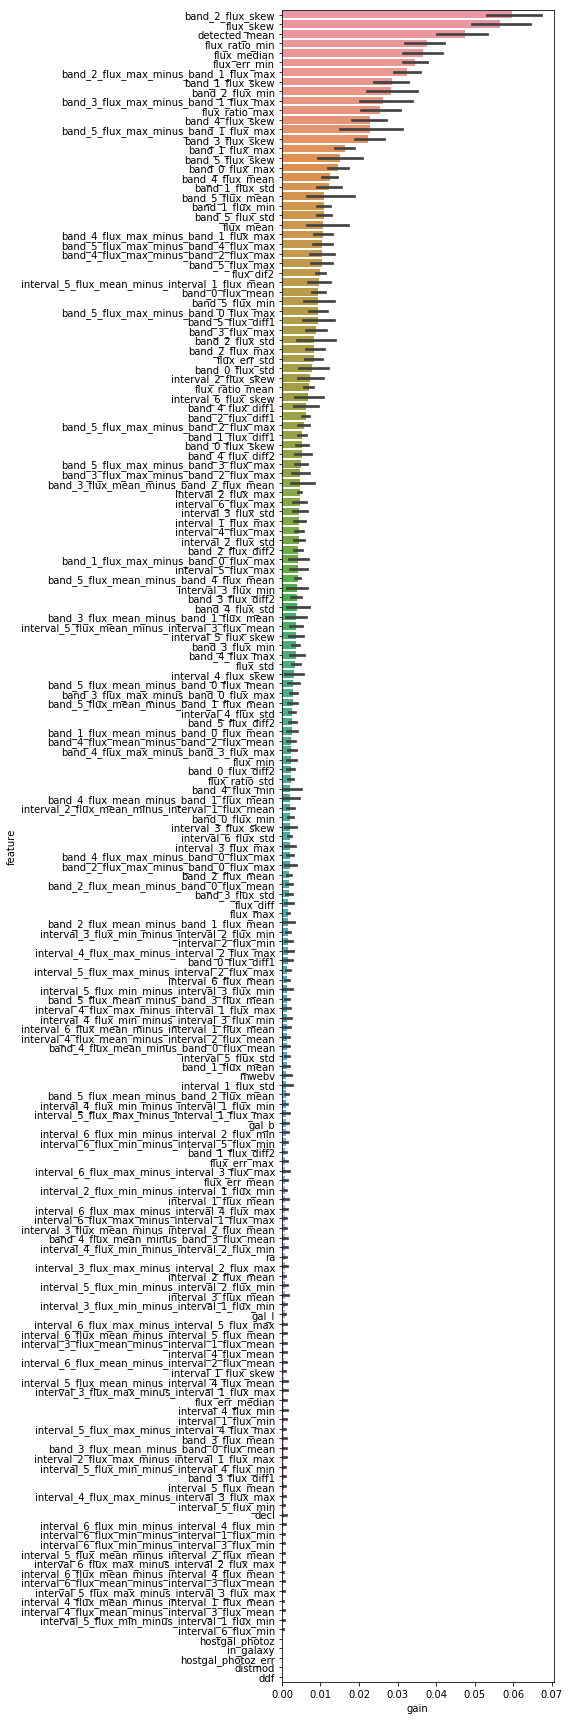

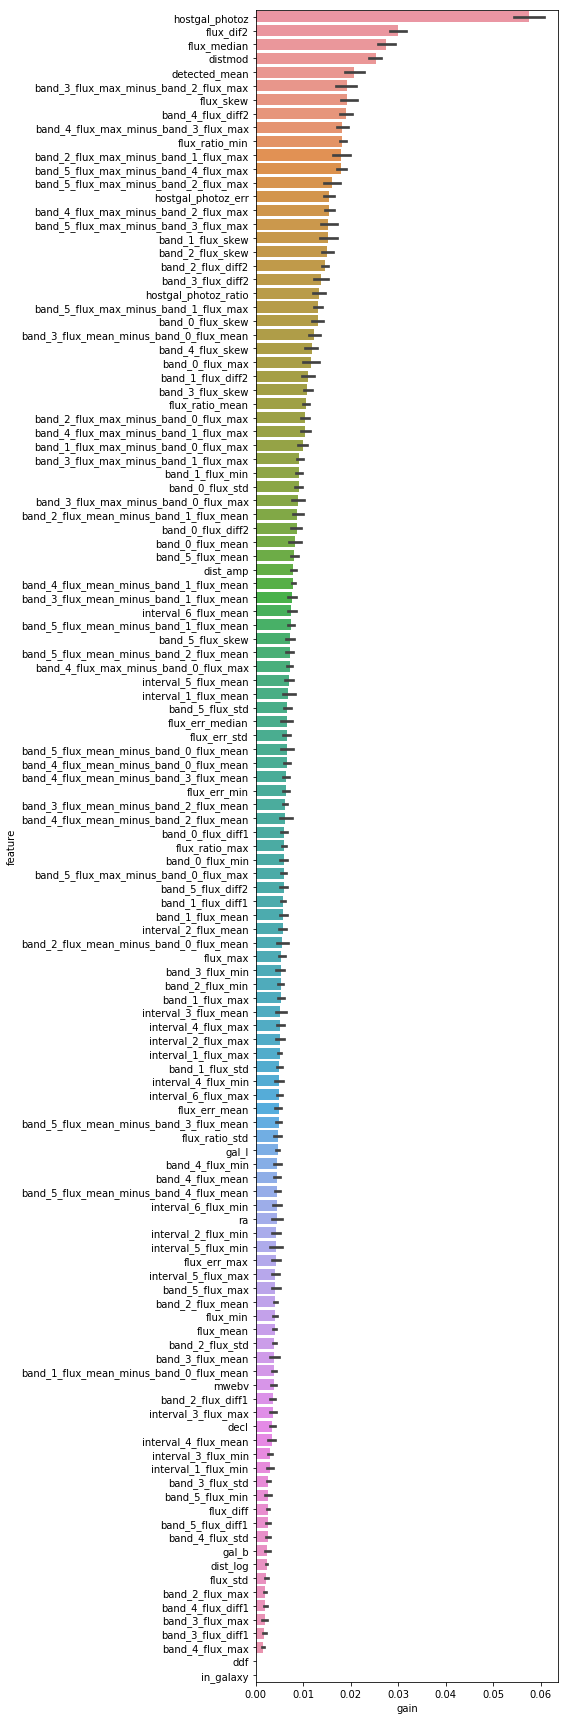

In [17]:
gc.enable()
create_logger()

train = pd.read_csv('../input/training_set.csv')

meta_train = pd.read_csv('../input/training_set_metadata.csv')

full_train_in_gal, full_train_out_gal = fabriquer_feat(train, meta_train)

del train

print('Training begins...')

y_list = []
preds_list = []
clf_list = []
val_score_list = []
for df in [full_train_in_gal, full_train_out_gal]:
    del df['object_id']
    df_mean = df.mean(axis=0)
    df.fillna(df_mean, inplace=True)
    y = df['target']
    y_list.append(y)
    del df['target']
    gc.collect()
    get_logger().info(df.columns)

    clfs, importances, preds, val_score = train_classifiers(df, y)
    save_importances(importances_=importances)
    preds_list.append(preds)
    clf_list.append(clfs)
    val_score_list.append(val_score)

    

    
    
    


print('Let us check the logloss when objects are trained separately...')
# all_y = pd.concat(y_list, ignore_index=True)
all_y = np.concatenate((y_list[0], y_list[1]), axis=0)

preds_in_gal = preds_list[0]
preds_out_gal = preds_list[1]
in_classes = [6, 16, 53, 65, 92]
out_classes = [15, 42, 52, 62, 64, 67, 88, 90, 95]

in_df = set_df(preds_in_gal, in_classes)
out_df = set_df(preds_out_gal, out_classes)
in_out_df = pd.concat([in_df, out_df], axis=0).fillna(0)


val_score_tot = multi_weighted_logloss(y_true=all_y, y_preds=in_out_df.values)

print('Separate MULTI WEIGHTED LOG LOSS : %.5f ' % val_score_tot)

val_score_list.append(val_score_tot)

score_tab = pd.DataFrame({'Model':['Galaxy_Model', 'Extragalaxy_Model','Bi_Model'], 'Score':val_score_list})
print(score_tab)
score_tab.to_csv(r'../feat/validation_scores_{}.csv'.format(datetime.datetime.now().strftime('%m%d_%H%M')), index=False)